In [1]:
import sys; sys.path.append("/scratch/glatzlandre/kreisel_deep_learning")  # working dir

In [2]:
from dataset import get_train, get_val, get_test

2023-06-12 21:54:15.651886: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 21:54:15.703644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 21:54:16.420720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import pandas as pd
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
HEIGHT = 700
WIDTH = 700

In [6]:
train_generator_normal = get_train('normal')
train_images_normal = train_generator_normal


validation_generator_normal = get_val('normal')
val_images_normal = validation_generator_normal
test_generator_normal = get_test('normal')
test_images_normal = test_generator_normal

train_generator_canny = get_train('canny')
train_images_canny = train_generator_canny
validation_generator_canny = get_val('canny')
val_images_canny = validation_generator_canny
test_generator_canny = get_test('canny')
test_images_canny = test_generator_canny

train_generator_opencv = get_train('opencv')
train_images_opencv = train_generator_opencv
validation_generator_opencv = get_val('opencv')
val_images_opencv = validation_generator_opencv
test_generator_opencv = get_test('opencv')
test_images_opencv = test_generator_opencv

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [7]:
def create_convolution_layers(input_img, input_shape, classes):
  model = keras.layers.BatchNormalization()(input_img)
  if input_shape[2] == 3:
    vgg16 = keras.applications.VGG16(include_top=False, weights='imagenet', classes=classes)
    for layer in vgg16.layers:
      layer.trainable = False
    model = vgg16(model)
    model = keras.layers.Conv2D(32, (3, 3), padding='same')(model)
  else:
    model = keras.layers.Conv2D(32, (2, 2), padding='same')(model)
  model = keras.layers.BatchNormalization()(model)
  model = keras.layers.Conv2D(32, (3, 3), activation='relu')(model)
  model = keras.layers.Conv2D(32, (3, 3), activation='relu')(model)
  model = keras.layers.MaxPooling2D((2, 2), (2, 2))(model)
  model = keras.layers.BatchNormalization()(model)
  model = keras.layers.Conv2D(64, (3, 3), activation='relu')(model)
  model = keras.layers.Conv2D(64, (3, 3), activation='relu')(model)
  model = keras.layers.MaxPooling2D((2, 2),padding='same')(model)
  model = keras.layers.BatchNormalization()(model)
  model = keras.layers.Dropout(0.25)(model)
  model = keras.layers.Resizing(22, 22)(input_img)
  model = keras.layers.BatchNormalization()(model)
  return model

In [8]:
# Normal Model
input_shape_normal = (HEIGHT, WIDTH, 3)
input_shape_canny = (HEIGHT, WIDTH, 1)
input_shape_opencv = (HEIGHT, WIDTH, 1)

normal_input = keras.layers.Input(shape=input_shape_normal)
canny_input = keras.layers.Input(shape=input_shape_canny)
opencv_input = keras.layers.Input(shape=input_shape_opencv)

model_normal = create_convolution_layers(normal_input, input_shape_normal, train_images_normal.classes)
model_canny = create_convolution_layers(canny_input, input_shape_canny, train_images_canny.classes)
model_opencv = create_convolution_layers(opencv_input, input_shape_opencv, train_images_opencv.classes)
conv = keras.layers.Concatenate()([model_normal, model_canny, model_opencv])

conv = keras.layers.GlobalAveragePooling2D()(conv)
conv = keras.layers.BatchNormalization()(conv)
dense = keras.layers.Dense(512)(conv)
dense = keras.layers.ReLU()(dense)
output = keras.layers.Dense(1, activation='sigmoid')(dense)

model = keras.models.Model(inputs=[normal_input, canny_input, opencv_input], outputs=output)

opt = keras.optimizers.AdamW(learning_rate=0.0001)


2023-06-12 21:54:19.021716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78918 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 700, 700, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 700, 700, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 700, 700, 1  0           []                               
                                )]                                                            

In [10]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [11]:
x_train_images_normal, y_train_images_normal = next(train_images_normal)
x_val_images_normal, y_val_images_normal = next(val_images_normal)
x_test_images_normal, y_test_images_normal = next(test_images_normal)

In [12]:
x_train_images_canny, y_train_images_canny = next(train_images_canny)
x_val_images_canny, y_val_images_canny = next(val_images_canny)
x_test_images_canny, y_test_images_canny = next(test_images_canny)

In [13]:
x_train_images_opencv, y_train_images_opencv = next(train_images_opencv)
x_val_images_opencv, y_val_images_opencv = next(val_images_opencv)
x_test_images_opencv, y_test_images_opencv = next(test_images_opencv)

In [14]:
print(x_train_images_normal.shape)
print(x_train_images_canny.shape)
print(x_train_images_opencv.shape)

(400, 700, 700, 3)
(400, 700, 700, 1)
(400, 700, 700, 1)


In [15]:
best_weights_file="weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='max')

callbacks = [checkpoint]

history = model.fit([x_train_images_normal, x_train_images_canny, x_train_images_opencv], y_train_images_normal,
          epochs=500,
          batch_size=32,
          callbacks=callbacks,
          validation_data=([x_val_images_normal, x_val_images_canny, x_val_images_opencv], y_val_images_normal),
          shuffle=True)

Epoch 1/500


2023-06-12 21:54:56.250805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-12 21:54:56.349045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-12 21:54:56.354515: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5622ef092c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-12 21:54:56.354580: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-06-12 21:54:56.362393: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-12 21:54:56.445721: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-12 21:54:56.521366:

13/13 [==============================] - 10s 161ms/step - loss: 0.7049 - accuracy: 0.4275 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 2/500
13/13 [==============================] - 1s 68ms/step - loss: 0.6853 - accuracy: 0.5650 - val_loss: 0.6929 - val_accuracy: 0.5700
Epoch 3/500
13/13 [==============================] - 1s 73ms/step - loss: 0.6677 - accuracy: 0.7275 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 4/500
13/13 [==============================] - 1s 67ms/step - loss: 0.6526 - accuracy: 0.7375 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 5/500
13/13 [==============================] - 1s 68ms/step - loss: 0.6364 - accuracy: 0.7625 - val_loss: 0.6899 - val_accuracy: 0.5100
Epoch 6/500
13/13 [==============================] - 1s 65ms/step - loss: 0.6251 - accuracy: 0.7475 - val_loss: 0.6888 - val_accuracy: 0.5100
Epoch 7/500
13/13 [==============================] - 1s 66ms/step - loss: 0.6152 - accuracy: 0.7300 - val_loss: 0.6872 - val_accuracy: 0.5100
Epoch 8/500
13/1

In [16]:
model.evaluate([x_test_images_normal, x_test_images_canny, x_test_images_opencv], y_test_images_normal, verbose=1)

4/4 [==============================] - 0s 46ms/step - loss: 0.5202 - accuracy: 0.7700


[0.5202308297157288, 0.7699999809265137]

In [17]:
def plot_acc_curve(trainHistory, savefigname=None):
    plt.figure(figsize=(8,6))
    plt.plot(trainHistory.history['accuracy'])
    plt.plot(trainHistory.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.grid()
    plt.title("Model Accuracy")
    if savefigname:
        plt.savefig(savefigname, bbox_inches='tight')
    plt.show()

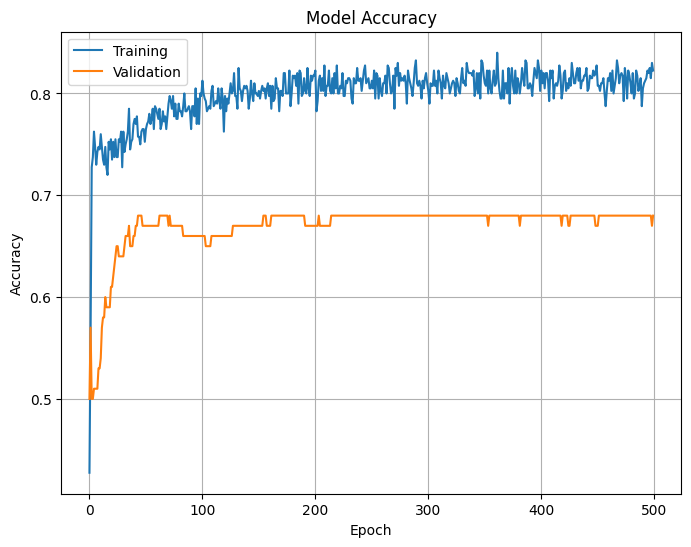

In [18]:
plot_acc_curve(history, savefigname='acc_curve.png')

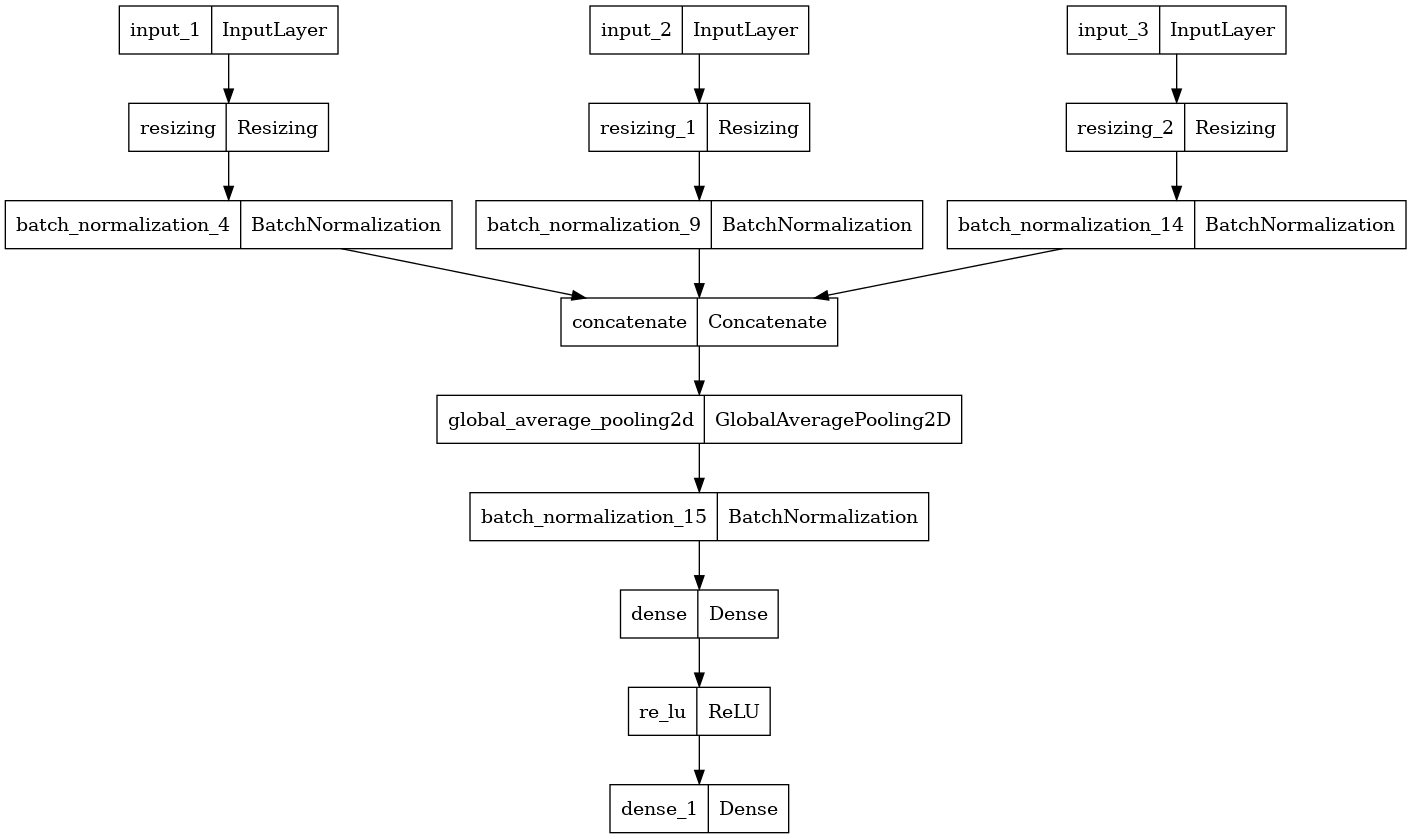

In [20]:
tf.keras.utils.plot_model(model)